In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import time
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
import keras
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# keras.backend.set_session(tf.Session(config=config))
import segmentation_models as sm

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

### Sidewalk segmentation model definition

In [3]:
BACKBONE = 'efficientnetb3'

#create model
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
model.load_weights('unet-efficientnetb3-berkeley-drivable-sidewalk-192x320.h5')

In [4]:
preprocess_input = sm.get_preprocessing(BACKBONE)
def image_preprocessing(image, size=(192, 320)):
    # convert color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # apply preprocessing
    image = cv2.resize(image, (size[1], size[0]), cv2.INTER_LINEAR)
    image = preprocess_input(image)
    img_processed = np.expand_dims(image, axis=0)
    return img_processed

### Model testing and visualization

In [5]:
def visual_seg_result(image, seg_mask):
    # Generate fake R & B color dimensions, stack with G
    size = (seg_mask[0].shape[:2])
    blanks = np.zeros(size).astype(np.uint8)
    lane_drawn = np.dstack((blanks, seg_mask[0], blanks))

    # # Re-size to match the original image
    lane_image = cv2.resize(lane_drawn, (image.shape[1], image.shape[0]))

    # Merge the lane drawing onto the original image
    result = 0.7* denormalize(frame_raw) + 0.3 * lane_image
    return result

  0%|          | 0/19 [00:00<?, ?it/s]

[INFO] single frame of size (192, 320) took 4.5702 seconds


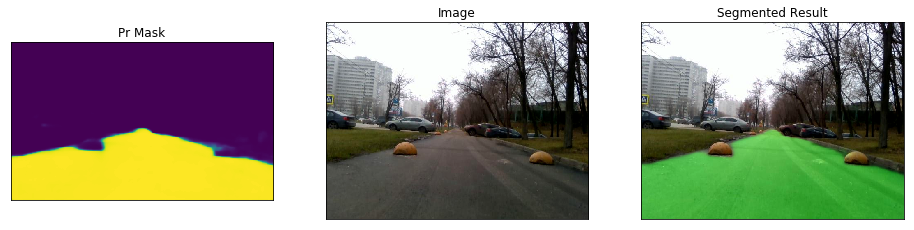

  5%|▌         | 1/19 [00:05<01:31,  5.10s/it]

[INFO] single frame of size (192, 320) took 0.3346 seconds


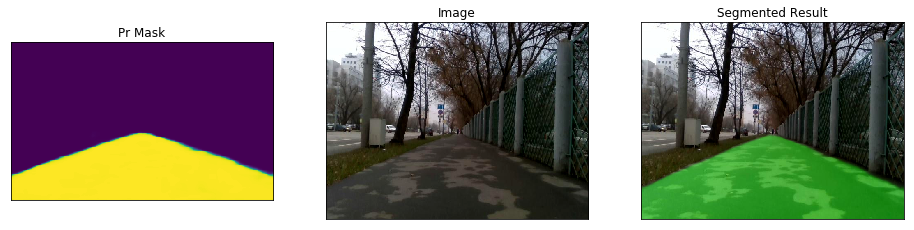

 11%|█         | 2/19 [00:06<01:06,  3.89s/it]

[INFO] single frame of size (192, 320) took 0.3437 seconds


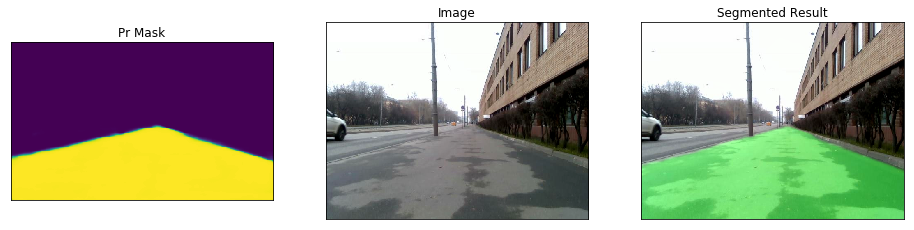

 16%|█▌        | 3/19 [00:06<00:46,  2.93s/it]

[INFO] single frame of size (192, 320) took 0.3475 seconds


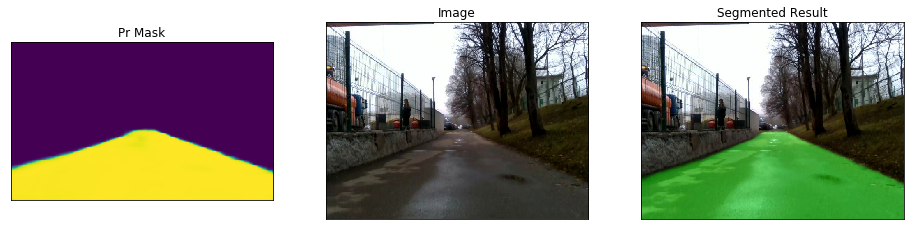

 21%|██        | 4/19 [00:07<00:34,  2.31s/it]

[INFO] single frame of size (192, 320) took 0.3277 seconds


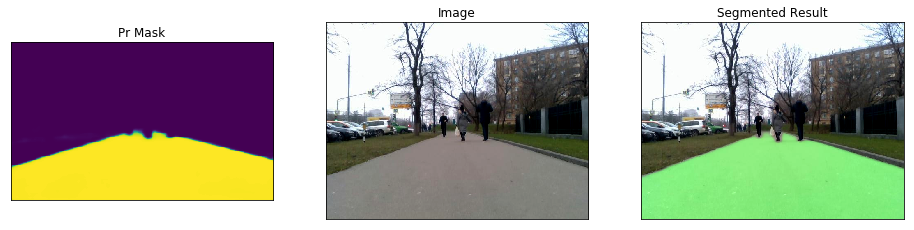

 26%|██▋       | 5/19 [00:08<00:26,  1.86s/it]

[INFO] single frame of size (192, 320) took 0.3226 seconds


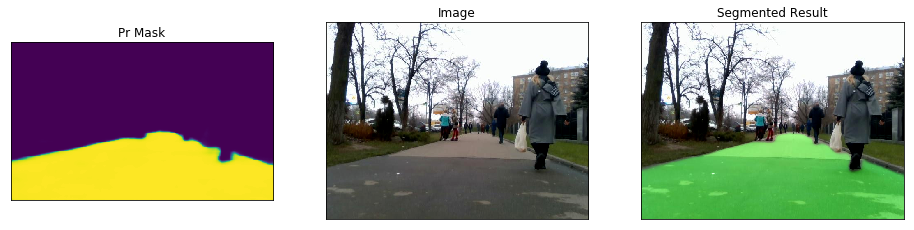

 32%|███▏      | 6/19 [00:09<00:20,  1.55s/it]

[INFO] single frame of size (192, 320) took 0.3681 seconds


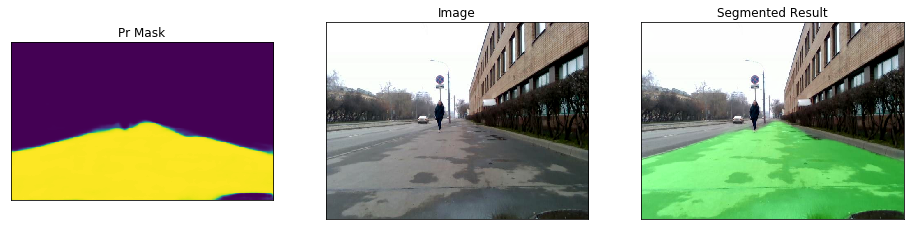

 37%|███▋      | 7/19 [00:10<00:15,  1.32s/it]

[INFO] single frame of size (192, 320) took 0.3207 seconds


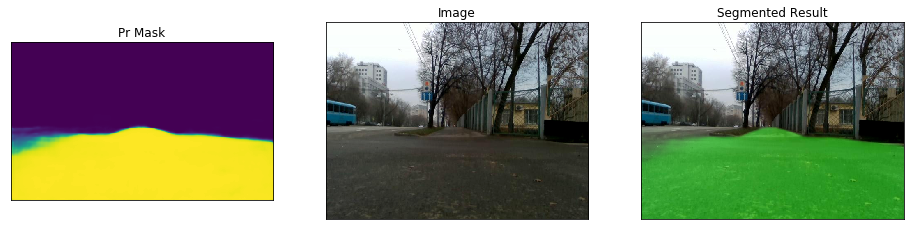

 42%|████▏     | 8/19 [00:10<00:12,  1.15s/it]

[INFO] single frame of size (192, 320) took 0.3457 seconds


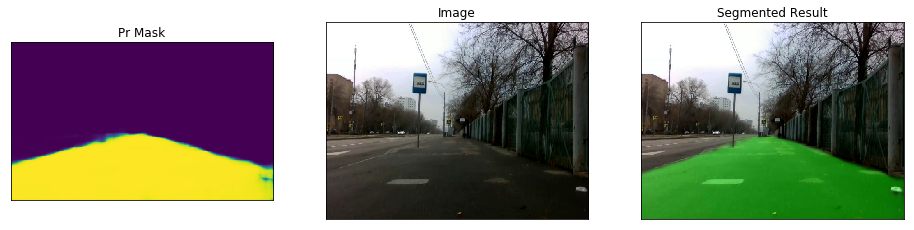

 47%|████▋     | 9/19 [00:11<00:10,  1.04s/it]

[INFO] single frame of size (192, 320) took 0.3362 seconds


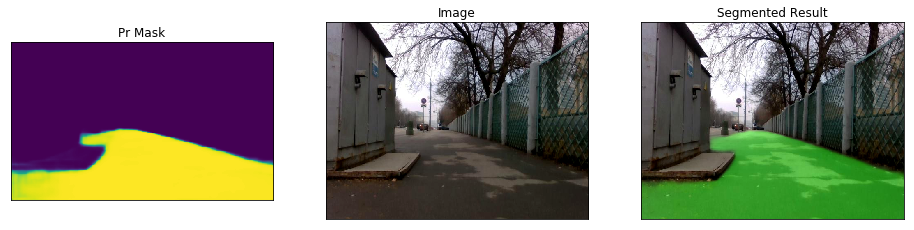

 53%|█████▎    | 10/19 [00:12<00:08,  1.02it/s]

[INFO] single frame of size (192, 320) took 0.5459 seconds


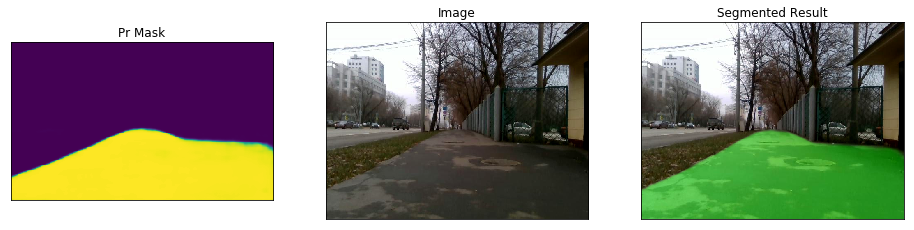

 58%|█████▊    | 11/19 [00:13<00:08,  1.00s/it]

[INFO] single frame of size (192, 320) took 0.3226 seconds


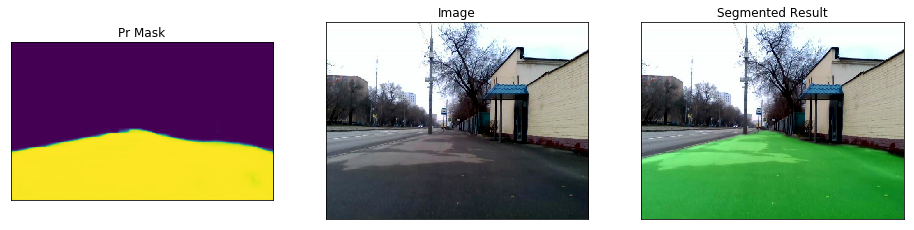

 63%|██████▎   | 12/19 [00:14<00:06,  1.05it/s]

[INFO] single frame of size (192, 320) took 0.3191 seconds


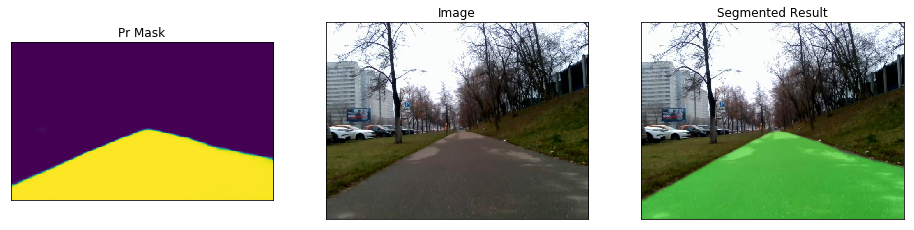

 68%|██████▊   | 13/19 [00:15<00:05,  1.09it/s]

[INFO] single frame of size (192, 320) took 0.3259 seconds


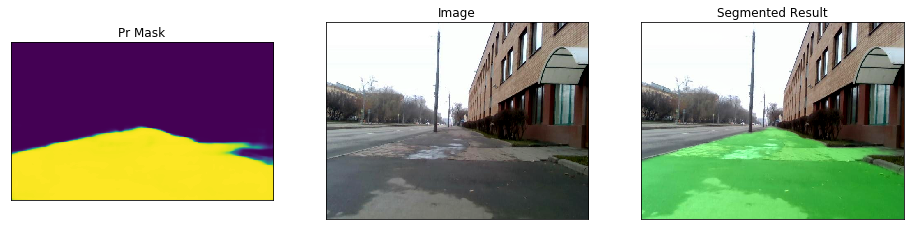

 74%|███████▎  | 14/19 [00:16<00:04,  1.13it/s]

[INFO] single frame of size (192, 320) took 0.3189 seconds


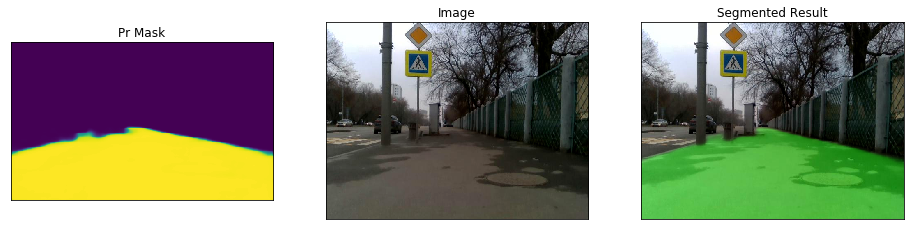

 79%|███████▉  | 15/19 [00:16<00:03,  1.19it/s]

[INFO] single frame of size (192, 320) took 0.3254 seconds


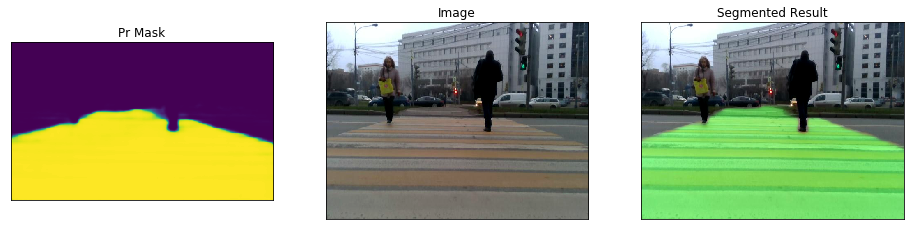

 84%|████████▍ | 16/19 [00:17<00:02,  1.19it/s]

[INFO] single frame of size (192, 320) took 0.3383 seconds


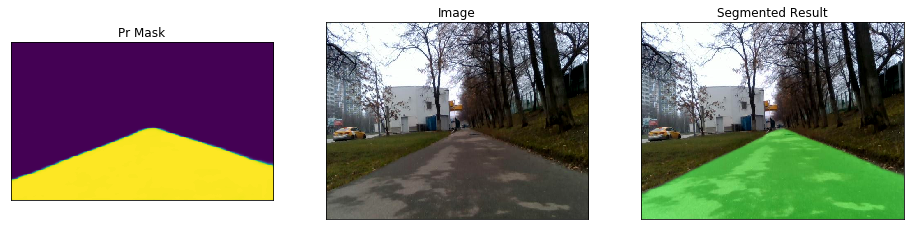

 89%|████████▉ | 17/19 [00:18<00:01,  1.16it/s]

[INFO] single frame of size (192, 320) took 0.3306 seconds


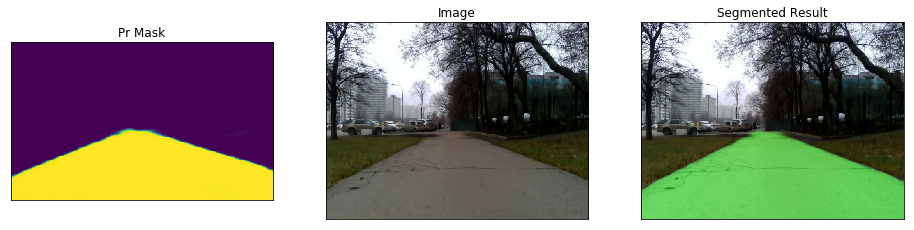

 95%|█████████▍| 18/19 [00:19<00:00,  1.18it/s]

[INFO] single frame of size (192, 320) took 0.6505 seconds


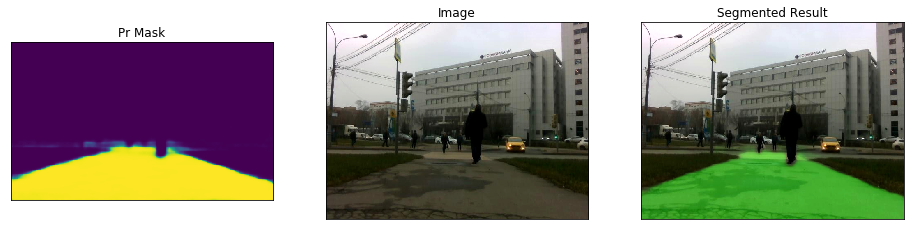

100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

[INFO] Mean FPS 2.7216 Hz


In [6]:
PATH_TO_FRAMES = 'images'
FPS = []
for im_path in tqdm( os.listdir(PATH_TO_FRAMES) ):
    # get raw frames from video stream
    frame_raw = cv2.imread(os.path.join(PATH_TO_FRAMES, im_path))
    
    # preprocess raw frames
    frame = image_preprocessing(frame_raw)
    # predict segmentation mask from the frame
    start = time.time()
    pr_mask = model.predict(frame)
    end = time.time()
    dt = end-start
    FPS.append(1./dt)
    segmented_result = visual_seg_result(frame_raw[:,:,(2,1,0)], pr_mask)
    print("[INFO] single frame of size {} took {:.4f} seconds".format(frame.shape[1:3], dt))

    visualize(
        image=denormalize(frame_raw[:,:,(2,1,0)]),
        pr_mask=pr_mask.squeeze(),
        segmented_result=denormalize(segmented_result[...,(2,1,0)])
    )

print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))


### Extracting a contour from segmented results

In [14]:
def get_binary(pr_mask):
    mask = pr_mask.squeeze()
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)
    mask255 = np.array(255*denormalize(blurred), dtype=np.uint8)
    _, thresh255 = cv2.threshold(mask255, np.mean(mask255), np.max(mask255), cv2.THRESH_BINARY)
    binary_mask = np.array( 1 - denormalize(thresh255), dtype=np.int )
    return binary_mask

In [20]:
import imutils
def get_contour(binary_mask):
    thresh = np.array(255*(1-binary_mask), dtype=np.uint8)

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    contour = sorted(cnts, key = cv2.contourArea, reverse=True)[0] # keep only the largest contour
    return contour

In [71]:
def draw(image, contour, route, goal):
    # draw the contour and center of the shape on the image
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
    
    # show the image
    visualize(contours=denormalize(image))
    plt.plot(route[:,0], route[:,1], linewidth=5)
    plt.plot(goal[0], goal[1], 'ro', markersize=5)

In [8]:
def gradient_planner(f, start_coords, end_coords, max_its):
    # GradientBasedPlanner : This function plans a path through a 2D
    # environment from a start to a destination based on the gradient of the
    # function f which is passed in as a 2D array. The two arguments
    # start_coords and end_coords denote the coordinates of the start and end
    # positions respectively in the array while max_its indicates an upper
    # bound on the number of iterations that the system can use before giving
    # up.
    # The output, route, is an array with 2 columns and n rows where the rows
    # correspond to the coordinates of the robot as it moves along the route.
    # The first column corresponds to the x coordinate and the second to the y coordinate

    [gy, gx] = np.gradient(-f)

    route = np.vstack( [np.array(start_coords), np.array(start_coords)] )
    for i in range(max_its):
        current_point = route[-1,:]
        # print(sum( abs(current_point-end_coords) ))
        if sum( abs(current_point-end_coords) ) < 5.0:
            print('Reached the goal !')
            break
        ix = int(round( current_point[1] ))
        iy = int(round( current_point[0] ))
        vx = gx[ix, iy]
        vy = gy[ix, iy]
        dt = 1 / np.linalg.norm([vx, vy])
        next_point = current_point + dt*np.array( [vx, vy] )
        route = np.vstack( [route, next_point] )
    route = route[1:,:]
        
    return route

In [77]:
from scipy.ndimage.morphology import distance_transform_edt as bwdist
def route_from_binary(binary_mask, goal):
    """
    compute route from a mask (and a goal pose)
    """
    # get repulsive potential
    d = bwdist(binary_mask==0)
    d2 = (d/100.) + 1 # Rescale and transform distances
    d0 = 1.2
    nu = 800
    repulsive = nu*((1./d2 - 1/d0)**2)
    repulsive [d2 > d0] = 0

    # get attractive potential
    # goal = [150, 140];
    start = [160, 190];
    nrows, ncols = binary_mask.shape
    [x, y] = np.meshgrid (np.arange(ncols), np.arange(nrows));
    xi = 1/700.
    attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )

    # Combined potential
    f = attractive + repulsive

    route = gradient_planner(f, start, goal, 700)
    return route

In [61]:
def goal_from_mask(binary_mask):
    drivable_indexes = np.asarray( np.where(binary_mask==0) )
    farest_y = np.min(drivable_indexes[0,:])
    farest_id = np.where(drivable_indexes[0,:]==farest_y)[0][0]
    farest_x = drivable_indexes[1, farest_id]

    farest_x += 5
    farest_y += 5
    goal = [farest_x, farest_y]
    return goal

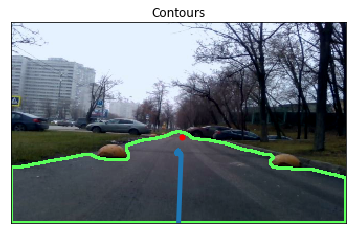

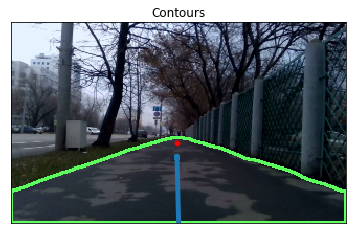

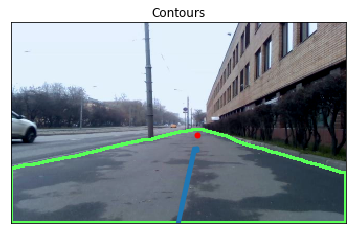

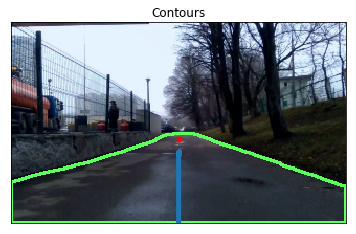

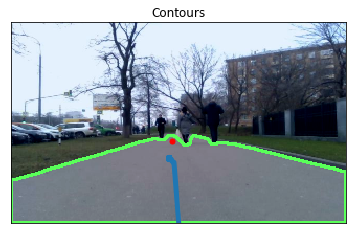

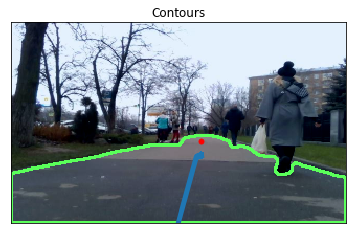

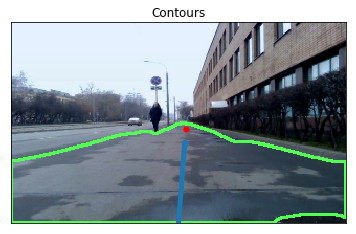

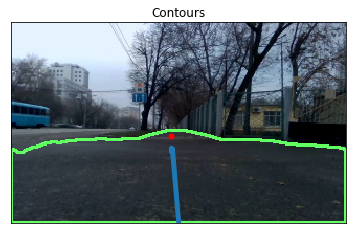

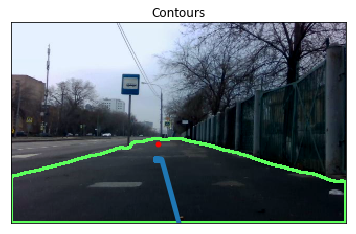

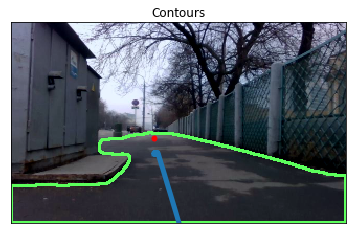

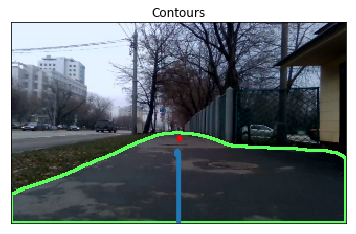

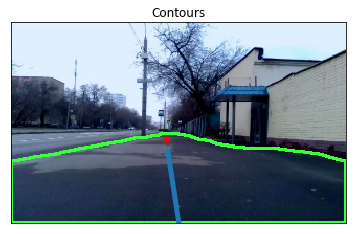

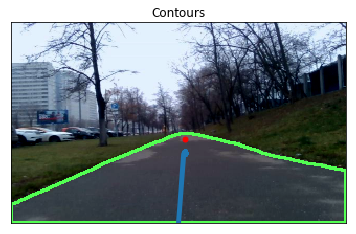

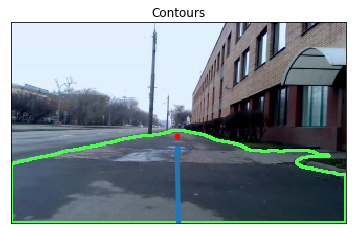

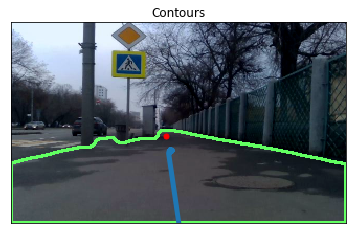

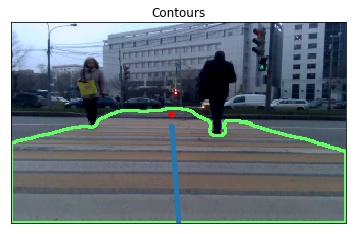

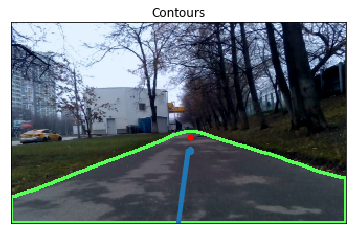

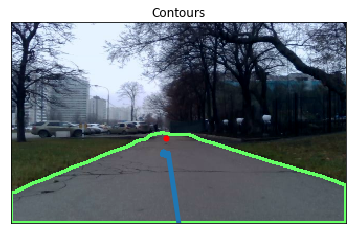

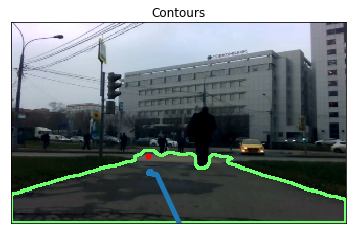

In [85]:
PATH_TO_IMAGES = 'images'
# PATH_TO_IMAGES = '/home/rus/Desktop/SelfDrivingCar/robot_scene_understanding/Sidewalk_segmentation/sidewalk_dataset/images/train/'
# PATH_TO_IMAGES = '/home/rus/Desktop/SelfDrivingCar/robot_scene_understanding/Sidewalk_segmentation/sidewalk_dataset/images/val/'

for im_path in os.listdir(PATH_TO_IMAGES):
    # get raw frames from video stream
    frame_raw = cv2.imread(os.path.join(PATH_TO_IMAGES, im_path))
    
    # preprocess raw frames
    frame = image_preprocessing(frame_raw)
    # predict segmentation mask from the frame
    pr_mask = model.predict(frame)
    
    # get binary mask
    binary_mask = get_binary(pr_mask)
    
    # get contour from segmented result
    c = get_contour(binary_mask)
    
    # get route from APF
    goal = goal_from_mask(binary_mask)
    route = route_from_binary(binary_mask, goal)
    
    plt.figure()
    draw(frame[0].copy(), c, route, goal)
    plt.show()